# CEEL82B Expt 6: Time Series Forecasting: Data, Analysis, and Practice
### Objective: 
To perform time series analysis: identifying the nature of the phenomenon represented by the sequence of observations, and forecasting

### Import libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
from tqdm import tqdm_notebook
from itertools import product
from datetime import datetime
from pandas.plotting import autocorrelation_plot
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [22]:
df = pd.read_csv('daily-min-temperatures.csv')
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [24]:
df['Date'] = pd.to_datetime(df['Date'])

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


Setting the date as index

In [26]:
df.set_index('Date', inplace=True)
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [28]:
day_map = {0:"Sunday",1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday"}
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday.map(day_map)
df.head()

,Temp,year,month,day,weekday
Date,,,,,
1981-01-01,20.7,1981,1,1,Wednesday
1981-01-02,17.9,1981,1,2,Thursday
1981-01-03,18.8,1981,1,3,Friday
1981-01-04,14.6,1981,1,4,Saturday
1981-01-05,15.8,1981,1,5,Sunday


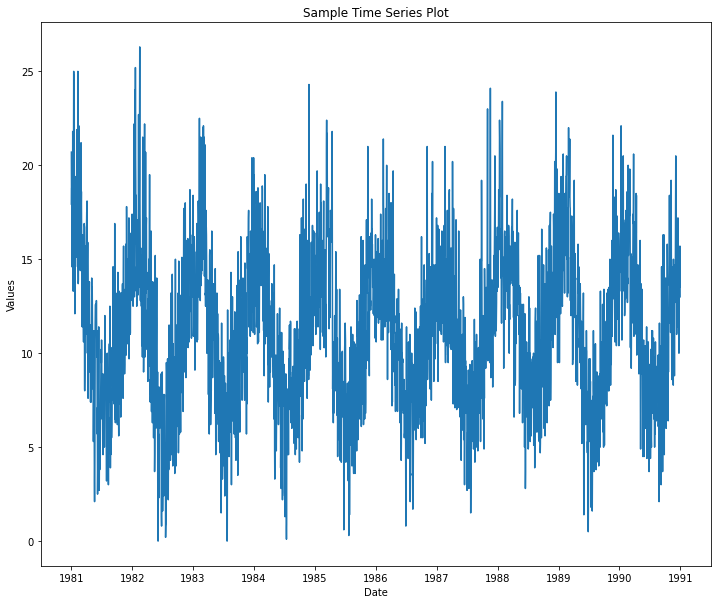

In [30]:
plt.figure(figsize=(12, 10))

plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Sample Time Series Plot")
 
plt.plot(df.Temp)

* We can observe that the dataset has a particular trend and seasonality for a fixed time period
* We can see a particular pattern repeating every year

### Decomposition of a Time Series
Decomposition of a time series can be performed by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual term.

<ipython-input-33-079deec9b63b>:12: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  mult_decomposition = seasonal_decompose(df['Temp'], freq=12)


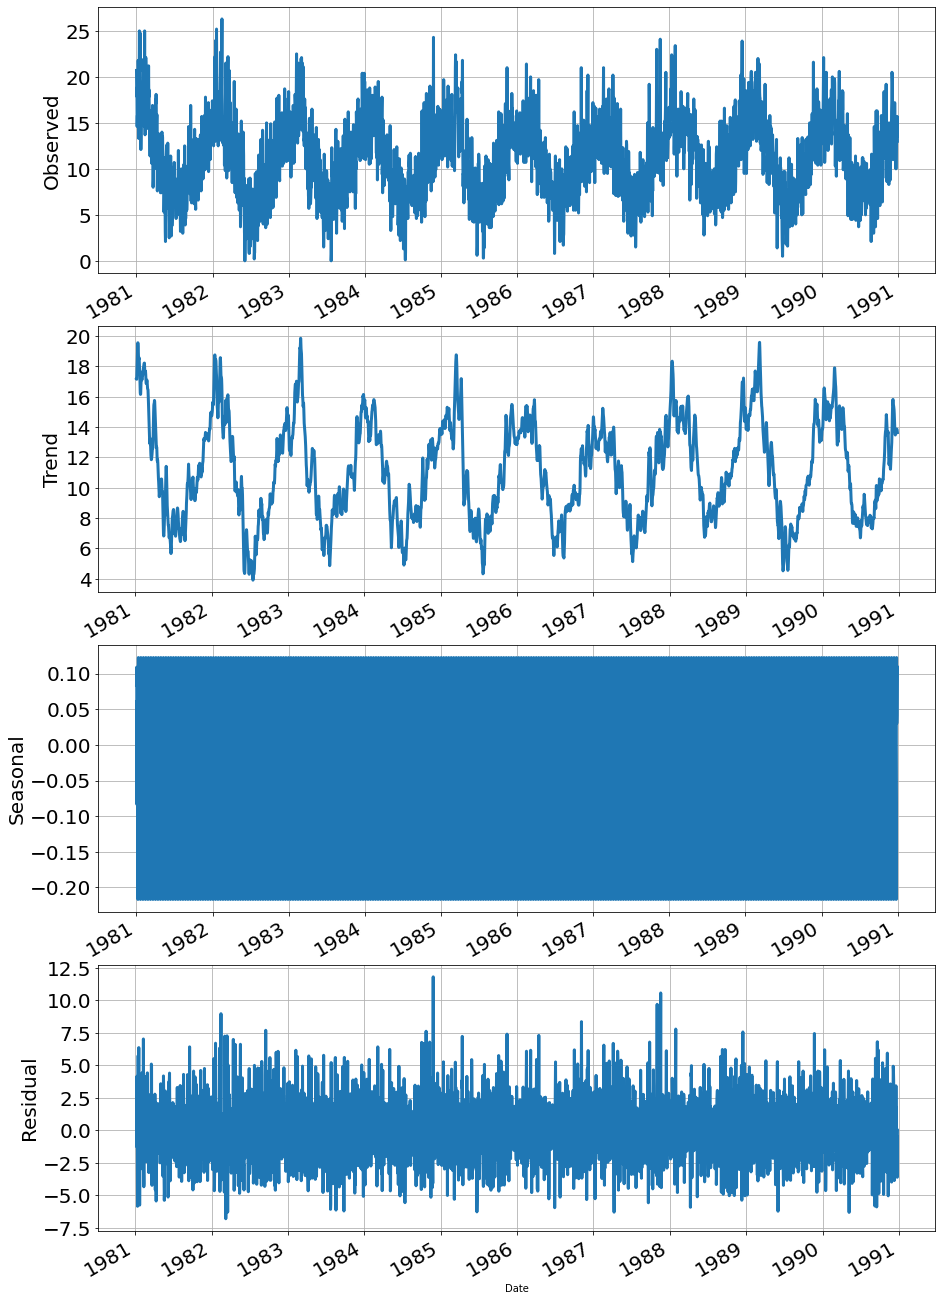

In [33]:
def plot_decompose(decompose_result):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,25))
    decompose_result.observed.plot(legend=False,ax=ax1,fontsize = 20,grid=True,linewidth = 3)
    ax1.set_ylabel("Observed",fontsize = 20)
    decompose_result.trend.plot(legend=False,ax=ax2,fontsize = 20,grid=True,linewidth = 3)
    ax2.set_ylabel("Trend",fontsize = 20)
    decompose_result.seasonal.plot(legend=False,ax=ax3,fontsize = 20,grid=True,linewidth = 3)
    ax3.set_ylabel("Seasonal",fontsize = 20)
    decompose_result.resid.plot(legend=False,ax=ax4,fontsize = 20,grid=True,linewidth = 3)
    ax4.set_ylabel("Residual",fontsize = 20)

mult_decomposition = seasonal_decompose(df['Temp'], freq=12) 
plot_decompose(mult_decomposition)

#### Let's zoom in on the period between 1983-1985, to get a clearer picture

<ipython-input-38-3a25a0c56b9f>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  mult_decomposition = seasonal_decompose(df[ (df['year']<1985) & (df['year']>1982) ]['Temp'], freq=12)


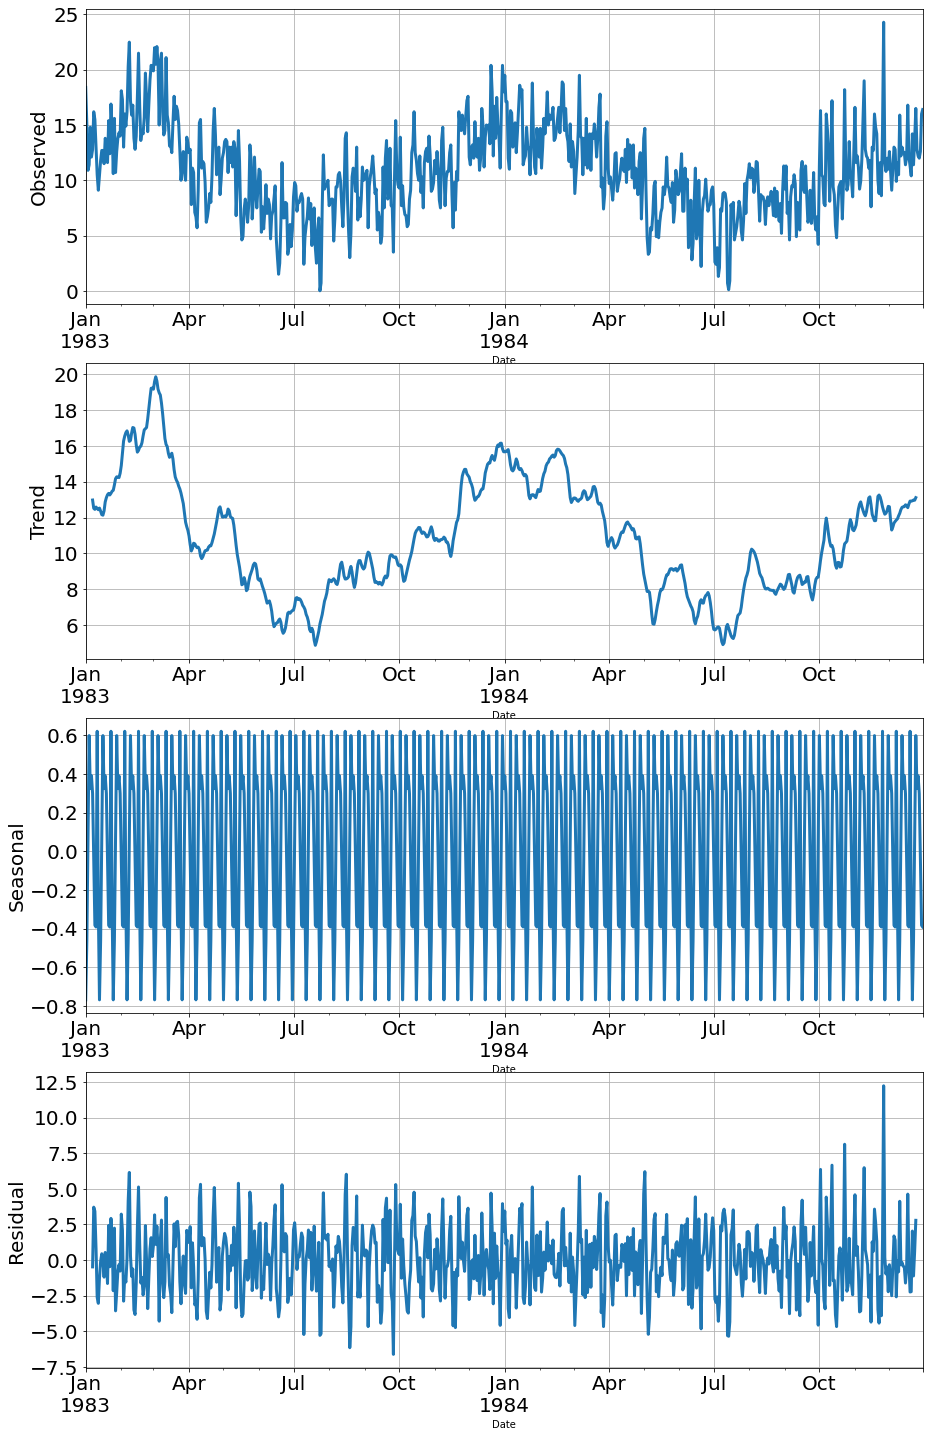

In [38]:
mult_decomposition = seasonal_decompose(df[ (df['year']<1985) & (df['year']>1982) ]['Temp'], freq=12) 
plot_decompose(mult_decomposition)

#### Stationarity Property
Stationarity is a property of a time series where the values of the series is not a function of time. So, the values are independent of time.
Hence the statistical properties of the series like mean, variance and autocorrelation are constant over time.
Autocorrelation of the series is nothing but the correlation of the series with its previous values.
A stationary time series is independent of seasonal effects as well.

### Checking for Stationary Property

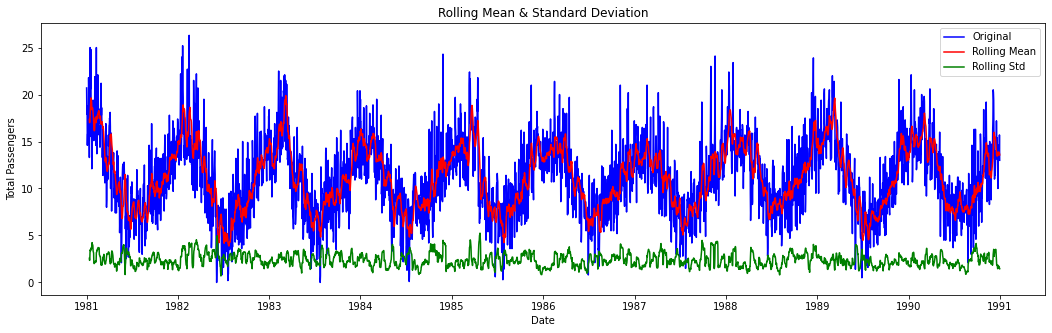

In [43]:
def rolling_stats(series):
    rolmean = series.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
    rolstd = series.rolling(window=12).std()
    
    orig = plt.plot(series, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.ylabel('Total Passengers')
    plt.xlabel('Date')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
plt.figure(figsize=(18,5))
rolling_stats(df["Temp"])

Zooming in

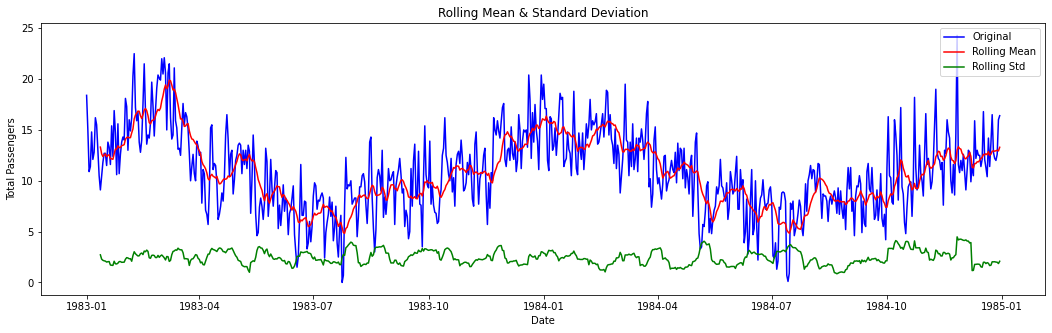

In [45]:
plt.figure(figsize=(18,5))
rolling_stats(df[ (df['year']<1985) & (df['year']>1982) ]['Temp'])

We see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time.

Since it has a trend, we can say that it is non-stationary time series data.

Confirming it with the ADF Test

In [47]:
def adfTest(y):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(y)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

adfTest(df["Temp"])

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


since the p value is less than 0.05 and there is a significant difference between the test statistic value and critical values.

We can accept the null hypothesis and conclude that the time series is a non-stationary one.

### Autocorrelation and Partial Autocorrelation Functions
Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.



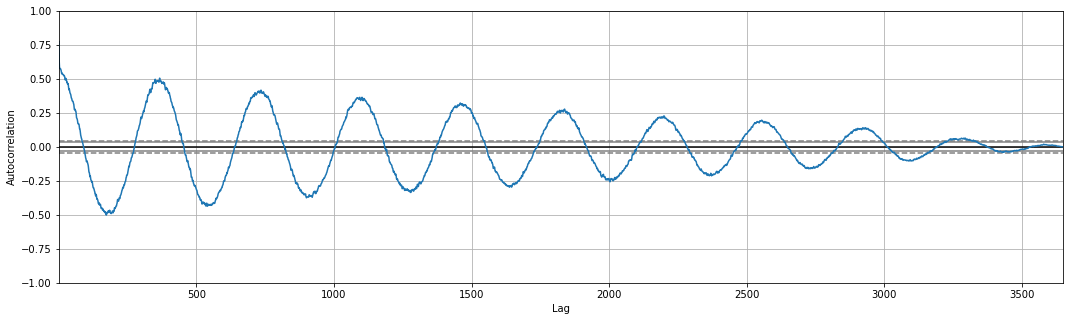

In [60]:
plt.figure(figsize=(18,5))
autocorrelation_plot(df["Temp"].tolist())

In [55]:
lag_acf = acf(df["Temp"], nlags=10)
lag_pacf = pacf(df["Temp"], nlags=10, method='ols')

C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


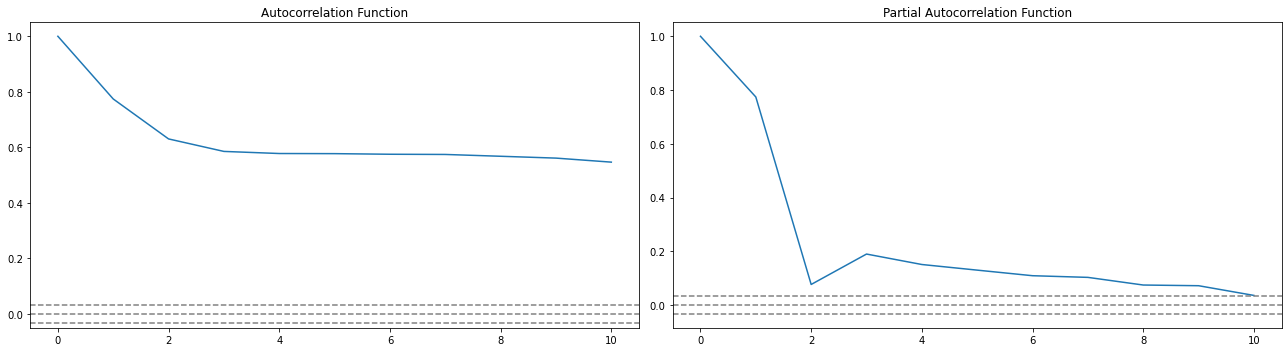

In [61]:
plt.figure(figsize=(18,5))
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #Add a horizontal line across the axis at y = 0.
plt.axhline(y = -1.96/np.sqrt(len(df["Temp"])), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(df["Temp"])), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(df["Temp"])), linestyle='--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(df["Temp"])), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout() #Automatically adjust subplot parameters to give specified padding.

### White noise: Differentiating signal from the noise.
Like a stationary series, the white noise is also not a function of time, and its mean and variance does not change over time. But, the white noise is completely random with a mean of 0, and there is no pattern.

### Converting the non-stationary series into a stationary series
Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary. So for our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. We can apply some sort of transformation to make the time-series stationary, like:

* Differencing the Series (once or more)
* Take the log of the series
* Take the nth root of the series
* Combination of the above

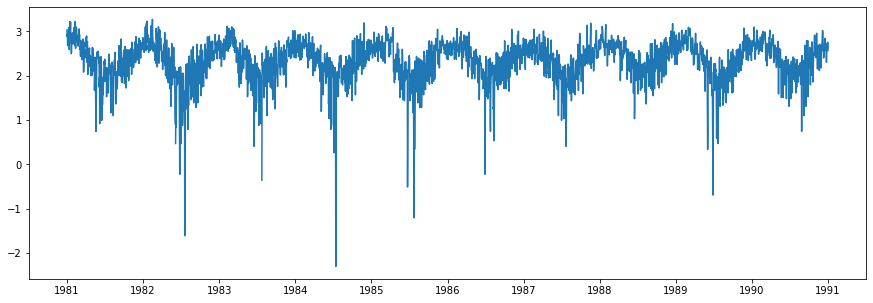

In [66]:
plt.figure(figsize=(15,5))
ts_log = np.log(df["Temp"])
plt.plot(ts_log)

DeTrend by differencing with the moving average

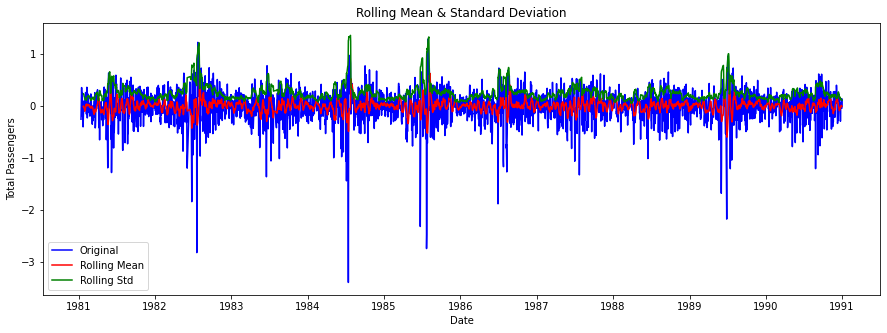

Results of Dickey-Fuller Test:
Test Statistic                -1.732175e+01
p-value                        5.476150e-30
#Lags Used                     2.000000e+01
Number of Observations Used    3.594000e+03
Critical Value (1%)           -3.432171e+00
Critical Value (5%)           -2.862345e+00
Critical Value (10%)          -2.567198e+00
dtype: float64


In [70]:
detrend = ts_log - ts_log.rolling(12).mean()
detrend.dropna(inplace=True)
plt.figure(figsize=(15,5))
# Check for stationary
rolling_stats(detrend)
adfTest(detrend)

Zooming in

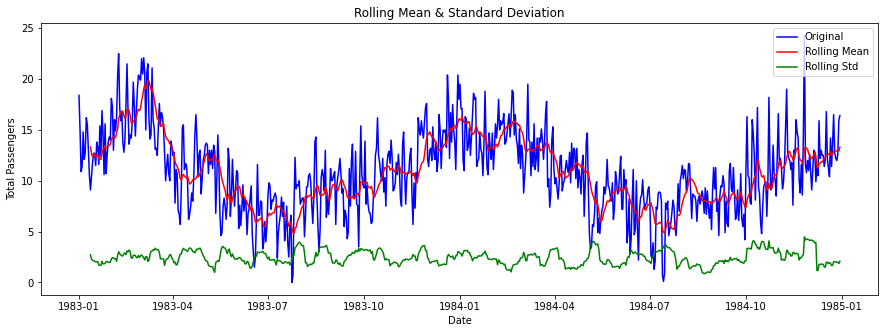

In [71]:
plt.figure(figsize=(15,5))
rolling_stats(df[ (df['year']<1985) & (df['year']>1982) ]['Temp'])

DeTrend by differencing with the weighted moving average (exponential weighting)

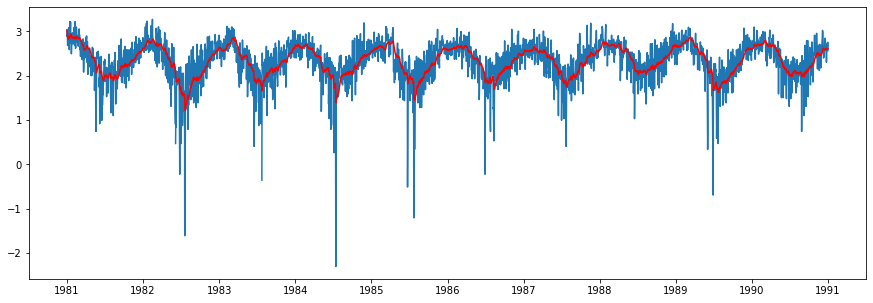

In [75]:
exp_weighted_avg = ts_log.ewm(halflife = 12).mean()
plt.figure(figsize=(15,5))

plt.plot(ts_log)
plt.plot(exp_weighted_avg, color = 'red')

Deseasonalise

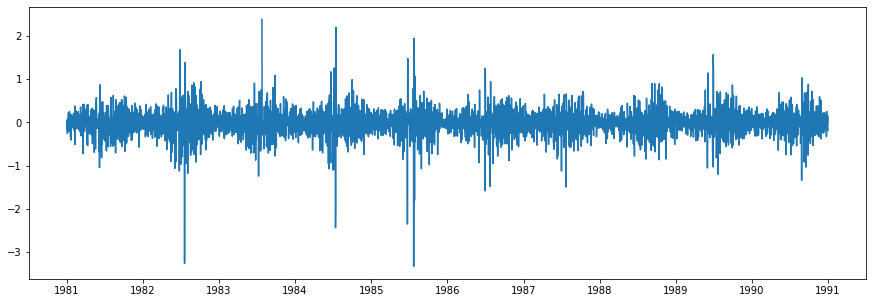

In [77]:
ts_log_diff = ts_log - ts_log.shift()

plt.figure(figsize=(15,5))
plt.plot(ts_log_diff)

In [107]:
df_temp = df_temp = df[df.year < 1983][["Temp"]]
df_temp.shape

(730, 1)

In [108]:
train = df_temp[:600]
test = df_temp[600:]
print(f'Size of train: {len(train)}, size of test: {len(test)}')

Size of train: 600, size of test: 130


In [109]:
def plot_prediction(y_pred, label):
    train["Temp"].plot(legend=True, label="train")
    test["Temp"].plot(legend=True, label="test")
    y_pred.plot(legend=True, label="prediction")
    plt.title("Train and Test Using "+label)
    plt.show()

### Single Exponential Smoothing

alpha: 0.01 mae: 3.3943
alpha: 0.11 mae: 4.0146
alpha: 0.21 mae: 3.9023
alpha: 0.31 mae: 4.0078
alpha: 0.41 mae: 4.1901
alpha: 0.51 mae: 4.4243
alpha: 0.61 mae: 4.7062
alpha: 0.71 mae: 5.0123
alpha: 0.81 mae: 5.3133
alpha: 0.91 mae: 5.5692
best_alpha: 0.01 best_mae: 3.3943


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

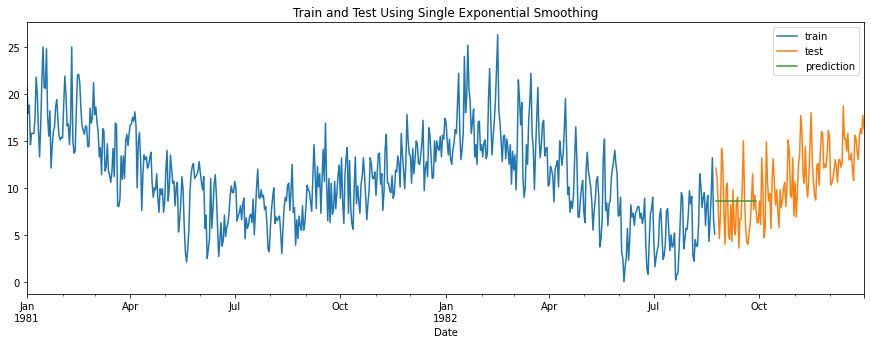

In [112]:
def ses_optimizer(train, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(train, alphas, step=130)

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(36)

plt.figure(figsize=(15,5))
plot_prediction(y_pred, "Single Exponential Smoothing")

### Double Exponential Smoothing


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

alpha: 0.01 beta: 0.01 mae: 5.3206
alpha: 0.01 beta: 0.11 mae: 2.886
alpha: 0.01 beta: 0.21 mae: 2.6953
alpha: 0.01 beta: 0.31 mae: 10.783
alpha: 0.01 beta: 0.41 mae: 11.716
alpha: 0.01 beta: 0.51 mae: 11.9952
alpha: 0.01 beta: 0.61 mae: 15.936
alpha: 0.01 beta: 0.71 mae: 16.7764
alpha: 0.01 beta: 0.81 mae: 25.5183
alpha: 0.01 beta: 0.91 mae: 10.6809
alpha: 0.11 beta: 0.01 mae: 4.8273
alpha: 0.11 beta: 0.11 mae: 5.8808
alpha: 0.11 beta: 0.21 mae: 2.4418
alpha: 0.11 beta: 0.31 mae: 3.3353
alpha: 0.11 beta: 0.41 mae: 4.0838
alpha: 0.11 beta: 0.51 mae: 6.4946
alpha: 0.11 beta: 0.61 mae: 6.3552
alpha: 0.11 beta: 0.71 mae: 11.8693
alpha: 0.11 beta: 0.81 mae: 31.643
alpha: 0.11 beta: 0.91 mae: 54.042
alpha: 0.21 beta: 0.01 mae: 4.4506
alpha: 0.21 beta: 0.11 mae: 2.3936
alpha: 0.21 beta: 0.21 mae: 5.4031
alpha: 0.21 beta: 0.31 mae: 11.4801
alpha: 0.21 beta: 0.41 mae: 20.7875
alpha: 0.21 beta: 0.51 mae: 30.4046
alpha: 0.21 beta: 0.61 mae: 32.8609
alpha: 0.21 beta: 0.71 mae: 24.9824
alpha: 0.21

C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

alpha: 0.31 beta: 0.11 mae: 3.4641
alpha: 0.31 beta: 0.21 mae: 10.8804
alpha: 0.31 beta: 0.31 mae: 18.9112
alpha: 0.31 beta: 0.41 mae: 23.236
alpha: 0.31 beta: 0.51 mae: 20.8955
alpha: 0.31 beta: 0.61 mae: 15.0225
alpha: 0.31 beta: 0.71 mae: 11.4664
alpha: 0.31 beta: 0.81 mae: 14.3167
alpha: 0.31 beta: 0.91 mae: 25.6127
alpha: 0.41 beta: 0.01 mae: 5.01
alpha: 0.41 beta: 0.11 mae: 6.1827
alpha: 0.41 beta: 0.21 mae: 15.81
alpha: 0.41 beta: 0.31 mae: 23.7206
alpha: 0.41 beta: 0.41 mae: 28.2562
alpha: 0.41 beta: 0.51 mae: 32.6481
alpha: 0.41 beta: 0.61 mae: 41.8917
alpha: 0.41 

C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

beta: 0.71 mae: 58.766
alpha: 0.41 beta: 0.81 mae: 83.0291
alpha: 0.41 beta: 0.91 mae: 112.1344
alpha: 0.51 beta: 0.01 mae: 5.4803
alpha: 0.51 beta: 0.11 mae: 9.5395
alpha: 0.51 beta: 0.21 mae: 21.9272
alpha: 0.51 beta: 0.31 mae: 33.2632
alpha: 0.51 beta: 0.41 mae: 44.9332
alpha: 0.51 beta: 0.51 mae: 60.8064
alpha: 0.51 beta: 0.61 mae: 83.035
alpha: 0.51 beta: 0.71 mae: 110.7972
alpha: 0.51 beta: 0.81 mae: 141.6695
alpha: 0.51 beta: 0.91 mae: 173.4868
alpha: 0.61 beta: 0.01 mae: 6.0621
alpha: 0.61 beta: 0.11 mae: 13.3357


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

alpha: 0.61 beta: 0.21 mae: 29.403
alpha: 0.61 beta: 0.31 mae: 46.0043
alpha: 0.61 beta: 0.41 mae: 65.3212
alpha: 0.61 beta: 0.51 mae: 89.6535
alpha: 0.61 beta: 0.61 mae: 118.9121
alpha: 0.61 beta: 0.71 mae: 151.3606
alpha: 0.61 beta: 0.81 mae: 185.2555
alpha: 0.61 beta: 0.91 mae: 219.5574
alpha: 0.71 beta: 0.01 mae: 6.6722
alpha: 0.71 beta: 0.11 mae: 17.2344
alpha: 0.71 beta: 0.21 mae: 37.0873
alpha: 0.71 beta: 0.31 mae: 58.6269


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

alpha: 0.71 beta: 0.41 mae: 83.5712
alpha: 0.71 beta: 0.51 mae: 112.7316
alpha: 0.71 beta: 0.61 mae: 145.003
alpha: 0.71 beta: 0.71 mae: 178.5339
alpha: 0.71 beta: 0.81 mae: 211.6387
alpha: 0.71 beta: 0.91 mae: 242.8675
alpha: 0.81 beta: 0.01 mae: 7.2468
alpha: 0.81 beta: 0.11 mae: 20.715
alpha: 0.81 beta: 0.21 mae: 43.707
alpha: 0.81 beta: 0.31 mae: 68.6808
alpha: 0.81 beta: 0.41 mae: 96.5092
alpha: 0.81 beta: 0.51 mae: 126.8464
alpha: 0.81 beta: 0.61 mae: 157.896
alpha: 0.81 beta: 0.71 mae: 187.4192


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

alpha: 0.81 beta: 0.81 mae: 213.2663
alpha: 0.81 beta: 0.91 mae: 233.4386
alpha: 0.91 beta: 0.01 mae: 7.716
alpha: 0.91 beta: 0.11 mae: 23.352
alpha: 0.91 beta: 0.21 mae: 48.2418
alpha: 0.91 beta: 0.31 mae: 74.5299
alpha: 0.91 beta: 0.41 mae: 102.1285
alpha: 0.91 beta: 0.51 mae: 129.7187
alpha: 0.91 beta: 0.61 mae: 154.8799
alpha: 0.91 beta: 0.71 mae: 174.9701
alpha: 0.91 beta: 0.81 mae: 187.586
alpha: 0.91 beta: 0.91 mae: 190.7335
best_alpha: 0.21 best_beta: 0.11 best_mae: 2.3936


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

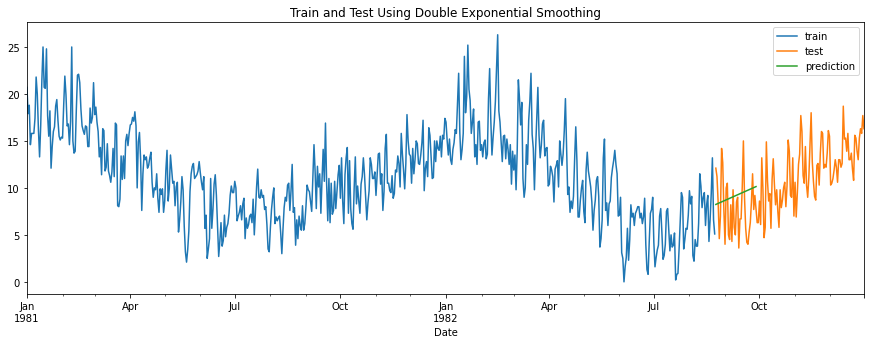

In [113]:
def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=130)
#54.10

des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred = des_model.forecast(36)

plt.figure(figsize=(15,5))
plot_prediction(y_pred, "Double Exponential Smoothing")

Triple Exponential smoothing

C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

[0.1, 0.1, 0.1, 5.08]
[0.1, 0.1, 0.3, 4.36]
[0.1, 0.1, 0.5, 3.83]
[0.1, 0.1, 0.7, 3.52]
[0.1, 0.1, 0.9, 3.61]
[0.1, 0.3, 0.1, 5.19]
[0.1, 0.3, 0.3, 4.45]
[0.1, 0.3, 0.5, 4.08]
[0.1, 0.3, 0.7, 3.36]
[0.1, 0.3, 0.9, 3.31]
[0.1, 0.5, 0.1, 10.31]
[0.1, 0.5, 0.3, 9.27]
[0.1, 0.5, 0.5, 9.62]
[0.1, 0.5, 0.7, 17.5]
[0.1, 0.5, 0.9, 45.42]
[0.1, 0.7, 0.1, 14.23]
[0.1, 0.7, 0.3, 31.31]
[0.1, 0.7, 0.5, 57.45]
[0.1, 0.7, 0.7, 58.8]
[0.1, 0.7, 0.9, 3449.42]
[0.1, 0.9, 0.1, 62.71]
[0.1, 0.9, 0.3, 91.76]
[0.1, 0.9, 0.5, 67.52]


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

[0.1, 0.9, 0.7, 29116.57]
[0.1, 0.9, 0.9, 496254464.72]
[0.3, 0.1, 0.1, 5.89]
[0.3, 0.1, 0.3, 7.97]
[0.3, 0.1, 0.5, 10.55]
[0.3, 0.1, 0.7, 17.71]
[0.3, 0.1, 0.9, 31.12]
[0.3, 0.3, 0.1, 31.31]
[0.3, 0.3, 0.3, 32.57]
[0.3, 0.3, 0.5, 44.99]


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

[0.3, 0.3, 0.7, 48.79]
[0.3, 0.3, 0.9, 4692.43]
[0.3, 0.5, 0.1, 43.63]
[0.3, 0.5, 0.3, 4.22]
[0.3, 0.5, 0.5, 11285.03]
[0.3, 0.5, 0.7, 2998494.2]
[0.3, 0.5, 0.9, 1442337502.02]
[0.3, 0.7, 0.1, 6.03]
[0.3, 0.7, 0.3, 1487.44]
[0.3, 0.7, 0.5, 14320925.54]
[0.3, 0.7, 0.7, 1227863169.64]
[0.3, 0.7, 0.9, 431815329331.44]


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

[0.3, 0.9, 0.1, 802.44]
[0.3, 0.9, 0.3, 732085.81]
[0.3, 0.9, 0.5, 267674340.04]
[0.3, 0.9, 0.7, 43918868497.44]
[0.3, 0.9, 0.9, 2470266948919.84]
[0.5, 0.1, 0.1, 12.3]
[0.5, 0.1, 0.3, 19.55]
[0.5, 0.1, 0.5, 9.97]
[0.5, 0.1, 0.7, 10.44]
[0.5, 0.1, 0.9, 36.35]
[0.5, 0.3, 0.1, 37.69]


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

[0.5, 0.3, 0.3, 80.65]
[0.5, 0.3, 0.5, 160.34]
[0.5, 0.3, 0.7, 11572.6]
[0.5, 0.3, 0.9, 1610486.95]
[0.5, 0.5, 0.1, 70.03]
[0.5, 0.5, 0.3, 105.76]
[0.5, 0.5, 0.5, 97283.93]
[0.5, 0.5, 0.7, 14147234.02]
[0.5, 0.5, 0.9, 298175275.14]


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

[0.5, 0.7, 0.1, 20.95]
[0.5, 0.7, 0.3, 1854.57]
[0.5, 0.7, 0.5, 2738365.94]
[0.5, 0.7, 0.7, 122980238.45]
[0.5, 0.7, 0.9, 4161749475.18]
[0.5, 0.9, 0.1, 669.11]
[0.5, 0.9, 0.3, 8933.65]
[0.5, 0.9, 0.5, 1263750.59]
[0.5, 0.9, 0.7, 15287775.62]
[0.5, 0.9, 0.9, 1561171828.06]
[0.7, 0.1, 0.1, 18.2]
[0.7, 0.1, 0.3, 30.8]


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

[0.7, 0.1, 0.5, 21.5]
[0.7, 0.1, 0.7, 14.03]
[0.7, 0.1, 0.9, 25.59]
[0.7, 0.3, 0.1, 61.17]
[0.7, 0.3, 0.3, 206.27]
[0.7, 0.3, 0.5, 1641.02]
[0.7, 0.3, 0.7, 27177.06]
[0.7, 0.3, 0.9, 411585.07]
[0.7, 0.5, 0.1, 114.29]
[0.7, 0.5, 0.3, 3646.09]
[0.7, 0.5, 0.5, 48620.54]

C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information


[0.7, 0.5, 0.7, 396012.49]
[0.7, 0.5, 0.9, 19331470.67]
[0.7, 0.7, 0.1, 160.43]
[0.7, 0.7, 0.3, 5373.37]
[0.7, 0.7, 0.5, 75242.27]
[0.7, 0.7, 0.7, 18804747.98]
[0.7, 0.7, 0.9, 5038494044.45]
[0.7, 0.9, 0.1, 22.32]
[0.7, 0.9, 0.3, 41907.43]
[0.7, 0.9, 0.5, 19527912.94]
[0.7, 0.9, 0.7, 8375099178.61]


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

[0.7, 0.9, 0.9, 1714262109506.05]
[0.9, 0.1, 0.1, 19.52]
[0.9, 0.1, 0.3, 28.41]
[0.9, 0.1, 0.5, 63.83]
[0.9, 0.1, 0.7, 37.64]
[0.9, 0.1, 0.9, 25.25]
[0.9, 0.3, 0.1, 72.98]
[0.9, 0.3, 0.3, 352.46]
[0.9, 0.3, 0.5, 1229.06]
[0.9, 0.3, 0.7, 1148.96]


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

[0.9, 0.3, 0.9, 102330.89]
[0.9, 0.5, 0.1, 168.9]
[0.9, 0.5, 0.3, 480.43]
[0.9, 0.5, 0.5, 11432.44]
[0.9, 0.5, 0.7, 1697753.17]
[0.9, 0.5, 0.9, 271660743.36]
[0.9, 0.7, 0.1, 221.66]
[0.9, 0.7, 0.3, 10291.78]
[0.9, 0.7, 0.5, 2931534.9]
[0.9, 0.7, 0.7, 434959023.74]
[0.9, 0.7, 0.9, 154442427665.96]


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

[0.9, 0.9, 0.1, 1226.11]
[0.9, 0.9, 0.3, 201218.7]
[0.9, 0.9, 0.5, 37285399.56]
[0.9, 0.9, 0.7, 27347726246.34]
[0.9, 0.9, 0.9, 150801161007279.12]
best_alpha: 0.1 best_beta: 0.3 best_gamma: 0.9 best_mae: 3.3071


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

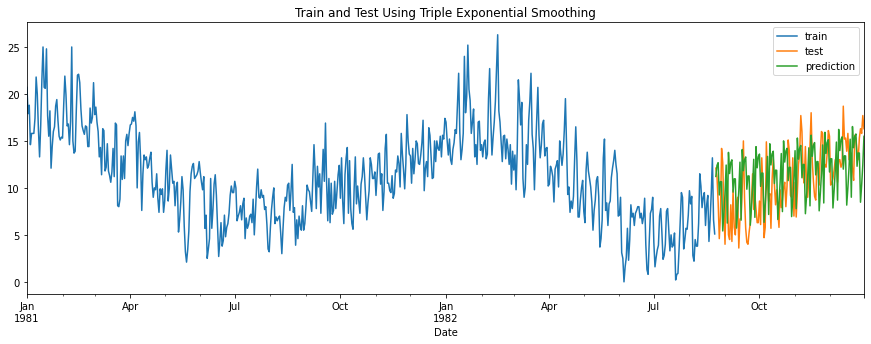

In [116]:
# Triple Exponential Smoothing (Holt-Winters)
import itertools

def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=130)

tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = tes_model.forecast(130)

plt.figure(figsize=(15,5))
plot_prediction(y_pred, "Triple Exponential Smoothing")

### ARIMA

C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

ARIMA(0, 0, 0) AIC=3582.55
ARIMA(0, 0, 1) AIC=3191.65
ARIMA(0, 0, 2) AIC=3063.62
ARIMA(0, 0, 3) AIC=2997.89
ARIMA(0, 1, 0) AIC=2943.14
ARIMA(0, 1, 1) AIC=2915.77
ARIMA(0, 1, 2) AIC=2831.68
ARIMA(0, 1, 3) AIC=2819.43
ARIMA(0, 2, 0) AIC=3438.53
ARIMA(0, 2, 1) AIC=2947.62


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

ARIMA(0, 2, 2) AIC=2921.16


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 3) AIC=2839.64
ARIMA(1, 0, 0) AIC=2898.35
ARIMA(1, 0, 1) AIC=2894.70


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 2) AIC=2838.75


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 3) AIC=2827.42
ARIMA(1, 1, 0) AIC=2930.87
ARIMA(1, 1, 1) AIC=2823.76


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

ARIMA(1, 1, 2) AIC=2818.69


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 3) AIC=2820.03
ARIMA(1, 2, 0) AIC=3278.95
ARIMA(2, 0, 0) AIC=2897.10


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

ARIMA(2, 0, 1) AIC=2832.11


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 0, 2) AIC=2826.89


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 0, 3) AIC=2828.20
ARIMA(2, 1, 0) AIC=2904.30
ARIMA(2, 1, 1) AIC=2817.69


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

ARIMA(2, 1, 2) AIC=2819.12


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 3) AIC=2822.49
ARIMA(2, 2, 0) AIC=3191.76
ARIMA(3, 0, 0) AIC=2883.96


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

ARIMA(3, 0, 1) AIC=2825.81


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(3, 0, 2) AIC=2827.14


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(3, 0, 3) AIC=2830.71
ARIMA(3, 1, 0) AIC=2884.84
ARIMA(3, 1, 1) AIC=2819.15


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

ARIMA(3, 1, 2) AIC=2821.49


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(3, 1, 3) AIC=2822.53
ARIMA(3, 2, 0) AIC=3142.73
Best ARIMA(2, 1, 1) AIC=2817.69


C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\aurko\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

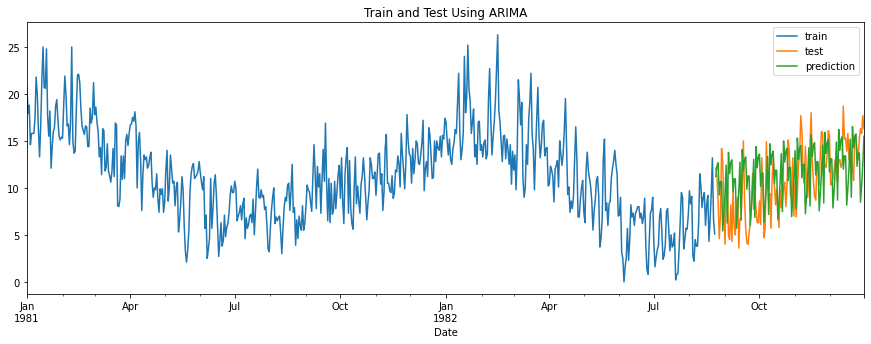

In [117]:
import itertools

p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arma_model_result = ARIMA(train, order).fit(disp=0)
            aic = arma_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

best_params_aic = arima_optimizer_aic(train, pdq)

# Tuned Model
arima_model = ARIMA(train, best_params_aic).fit(disp=0)
mean_absolute_error(test, y_pred)

plt.figure(figsize=(15,5))
plot_prediction(pd.Series(y_pred, index=test.index), "ARIMA")

### Conclusion:
1. Temperature forecast dataset was chosen to perform analysis. We found that the data is highly peridic and non stationary. We first applied decomposition and saw the Observed, Trend, Seasonal, Residual counterparts for the temperature data. Upon inspection, it was found that the graph is Non-stationary
2. To confirm this hypothesis, 2 tests were performed, first the rolling mean test, and next the ADF test. It was thus proven that the graph is non-stationary.We also found the autocorrelation and Partial autocorrelations to understand if the previous values play a part in prediction of the current value. And after that is established, we Moved on to convert non-stationary signal to stationary signal before temp forecasting.
3. We tried to perform operations like log on the curve, and also subtracted the rolling mean from the log to get a non-stationary curve. After trying to detrend it with the exponential average, again we try to use the log and finally get the deseasonalised graph.
4. After this, we applied the different models for prediction of the curve including Single Exponential Smoothing, double Exponential Smoothing, triple Exponential Smoothing, and finally ARIMA model, which gave the best prediction out of the 4. 